In [ ]:
# Run this cell to install DiffeRT and its dependencies, e.g., on Google Colab

try:
    import differt  # noqa: F401
except ImportError:
    import sys  # noqa: F401

    !{sys.executable} -m pip install differt[all]

# Coherent vs. Non-Coherent Radio Wave Propagation

In the modeling of electromagnetic wave propagation—particularly in ray-based methods—a critical distinction must be made between **coherent** and **non-coherent** propagation models. This section outlines the theoretical and practical implications of each approach, providing guidance for their appropriate use and referencing relevant scientific literature.

## Coherent Propagation

**Coherent propagation** refers to modeling techniques that preserve the **phase** of the electromagnetic fields. In such models, the total received signal is calculated as the **vector sum** of the complex amplitudes of all contributing multipath components. This approach captures both **constructive and destructive interference**, enabling the accurate representation of small-scale fading and phase-dependent phenomena such as beamforming.

Mathematically, the received power $P$ in a coherent model is often expressed as:

$$
P = A_e \left\|\boldsymbol{S}\right\| = A_e \left\| \frac{1}{\mu_0} \left(\sum\limits_{i} \boldsymbol{E}_i\right) \times \left(\sum\limits_{i} \boldsymbol{B}_i\right) \right\|,
$$

where $A_e$ is the effective antenna aperture, $\boldsymbol{S}$ is the Poynting vector, $\mu_0$ is the vacuum permeability, and $\boldsymbol{E}_i$ and $\boldsymbol{B}_i$ denote the electric and magnetic fields of the $i$-th propagation path, respectively.

Since the phase of both fields varies very rapidly—at the scale of the wavelength—and the geometric accuracy of most modeled scenes (especially in urban environments) is limited, accounting for the actual field phase can become counterproductive. It may introduce interference patterns that would not realistically occur due to measurement noise or geometric uncertainty. Moreover, simulating the exact $\boldsymbol{E}$ and $\boldsymbol{B}$ fields can be complex, particularly when including polarization effects, as antennas are often modeled using only a radiation pattern and polarization vector. For these reasons, among others, a non-coherent approach is often preferred.

## Non-Coherent Propagation

In contrast, **non-coherent** propagation models assume that the phase of individual multipath components is either unknown, random, or irrelevant. Consequently, the received signal is computed as a **power sum** rather than a complex vector sum. This approach significantly reduces computational complexity and avoids the numerical sensitivity associated with fine-scale geometric or frequency variations.

The total received power $P$ is typically given by:

$$
P = \sum\limits_{i} P_i = \sum\limits_{i} A_e \left\|\boldsymbol{S}_i\right\| = \sum\limits_{i} A_e \left\| \frac{1}{\mu_0} \boldsymbol{E}_i \times \boldsymbol{B}_i \right\|,
$$

where $P_i$ represents the power from the $i$-th ray, computed independently of phase.

## Comparing the Two Approaches

Below, we compare the **coherent** and **non-coherent** methods by generating a coverage map of the received power in a very simple scene.

First, we need to import a few packages, but the cell is hidden by default to increase readability.

In [ ]:
import jax.numpy as jnp
from plotly.subplots import make_subplots

from differt.em import (
    Dipole,
    materials,
    pointing_vector,
    reflection_coefficients,
    sp_directions,
)
from differt.geometry import (
    TriangleMesh,
    normalize,
)
from differt.plotting import draw_image, reuse, set_defaults
from differt.scene import (
    TriangleScene,
)
from differt.utils import dot

In this example, we limit ourselves to a very basic scene: a transmitter in a square room made of concrete, with no ceiling, and cubic metal reflector is placed in the middle to create more reflections.

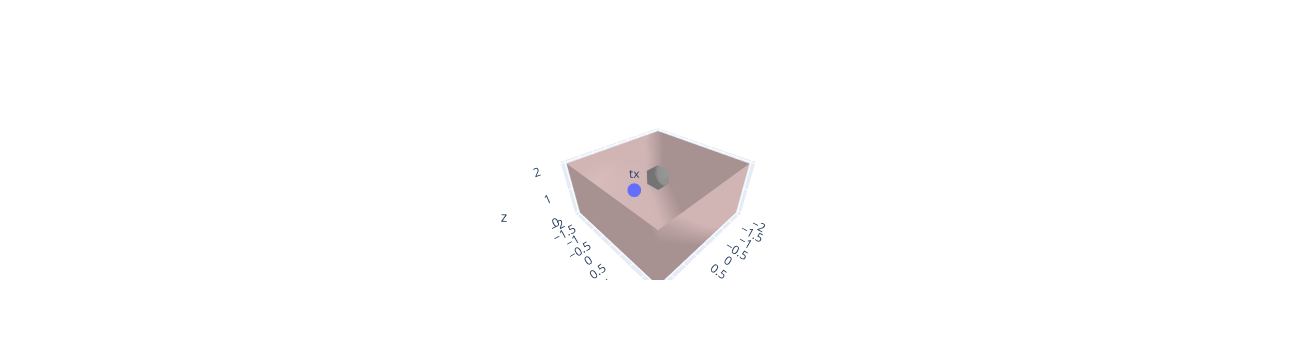

In [ ]:
set_defaults(
    "plotly"
)  # Our scene is simple, and Plotly is the best backend for online interactive plots :-)

mesh = TriangleMesh.box(length=4, width=4, height=2).set_materials(
    "itu_concrete"
).set_face_colors([0.82, 0.71, 0.71]).translate([
    0.0,
    0.0,
    1.0,
]) + TriangleMesh.box(
    length=0.5, width=0.5, height=0.5, with_top=True
).set_materials("itu_metal").set_face_colors([0.57, 0.57, 0.57]).translate([
    0.0,
    0.0,
    1.5,
])
scene = TriangleScene(transmitters=[1.0, 0.0, 1.5], mesh=mesh)
scene.plot()

Next, we estimate the coverage map by placing a grid of receivers in the scene, and by performing a Ray Tracing simulation for each of them.

Because DiffeRT works well with batches, all those path tracing operations can be performed at the same time.

In [ ]:
# Our scene can be simplified to quadrilaterals,
# so informing the code of that matter will make it run faster
scene = scene.set_assume_quads()
batch = (
    10,
    10,
)  # Warning: a too large batch could easily cause OOM issues
z0 = 1.0  # The z coordinate of the receivers
scene_grid = scene.with_receivers_grid(*batch, height=1.5)

# Only needed for plotting purposes
x, y, _ = jnp.unstack(scene_grid.receivers, axis=-1)

fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{"type": "scene"}], [{"type": "scene"}]],
)

with reuse(figure=fig) as fig:
    scene.plot(row=1, col=1)
    scene.plot(row=1, col=2)

    ant = Dipole(2.4e9)  # 2.4 GHz
    A_e = ant.aperture
    E = jnp.zeros((*batch, 3), dtype=jnp.complex64)
    B = jnp.zeros_like(E)
    P_nc = jnp.zeros(batch)

    eta_r = jnp.array([
        materials[mat_name].relative_permittivity(ant.frequency)
        for mat_name in scene.mesh.material_names
    ])
    n_r = jnp.sqrt(eta_r)

    for order in range(2):
        paths = scene_grid.compute_paths(order=order)
        E_i, B_i = ant.fields(paths.vertices[..., 1, :])

        if order > 0:
            # [*batch num_path_candidates order]
            obj_indices = paths.objects[..., 1:-1]
            # [*batch num_path_candidates order]
            mat_indices = jnp.take(
                scene.mesh.face_materials, obj_indices, axis=0
            )
            # [*batch num_path_candidates order 3]
            obj_normals = jnp.take(scene.mesh.normals, obj_indices, axis=0)
            # [*batch num_path_candidates order]
            obj_n_r = jnp.take(n_r, mat_indices, axis=0)
            # [*batch num_path_candidates order+1 3]
            path_segments = jnp.diff(paths.vertices, axis=-2)
            # [*batch num_path_candidates order+1 3],
            # [*batch num_path_candidates order+1 1]
            k, s = normalize(path_segments, keepdims=True)
            # [*batch num_path_candidates order 3]
            k_i = k[..., :-1, :]
            k_r = k[..., +1:, :]
            # [*batch num_path_candidates order 3]
            (e_i_s, e_i_p), (e_r_s, e_r_p) = sp_directions(
                k_i, k_r, obj_normals
            )
            # [*batch num_path_candidates order 1]
            cos_theta = dot(obj_normals, -k_i, keepdims=True)
            # [*batch num_path_candidates order 1]
            r_s, r_p = reflection_coefficients(obj_n_r[..., None], cos_theta)
            # [*batch num_path_candidates 1]
            r_s = jnp.prod(r_s, axis=-2)
            r_p = jnp.prod(r_p, axis=-2)
            # [*batch num_path_candidates order 3]
            (e_i_s, e_i_p), (e_r_s, e_r_p) = sp_directions(
                k_i, k_r, obj_normals
            )
            # [*batch num_path_candidates 1]
            E_i_s = dot(E_i, e_i_s[..., 0, :], keepdims=True)
            E_i_p = dot(E_i, e_i_p[..., 0, :], keepdims=True)
            B_i_s = dot(B_i, e_i_s[..., 0, :], keepdims=True)
            B_i_p = dot(B_i, e_i_p[..., 0, :], keepdims=True)
            # [*batch num_path_candidates 1]
            E_r_s = r_s * E_i_s
            E_r_p = r_p * E_i_p
            B_r_s = r_s * B_i_s
            B_r_p = r_p * B_i_p
            # [*batch num_path_candidates 3]
            E_r = E_r_s * e_r_s[..., -1, :] + E_r_p * e_r_p[..., -1, :]
            B_r = B_r_s * e_r_s[..., -1, :] + B_r_p * e_r_p[..., -1, :]
            # [*batch num_path_candidates 1]
            s_tot = s.sum(axis=-2)
            spreading_factor = s[..., 0, :] / s_tot  # Far-field approximation
            phase_shift = jnp.exp(1j * s_tot * ant.wavenumber)
            # [*batch num_path_candidates 3]
            E_r *= spreading_factor * phase_shift
            B_r *= spreading_factor * phase_shift
        else:
            # [*batch num_path_candidates 3]
            E_r = E_i
            B_r = B_i

        # 1 - Coherent

        # [*batch 3]
        E += jnp.sum(E_r, axis=-2, where=paths.mask[..., None])
        B += jnp.sum(B_r, axis=-2, where=paths.mask[..., None])

        # 2 - Non coherent

        P_nc += A_e * jnp.linalg.norm(pointing_vector(E_r, B_r), axis=-1).sum(
            axis=-1, where=paths.mask
        )

    S = pointing_vector(E, B)
    P_c = A_e * jnp.linalg.norm(S, axis=-1)
    G_c_dB = 10 * jnp.log10(P_c / ant.reference_power)
    G_nc_dB = 10 * jnp.log10(P_nc / ant.reference_power)

    draw_image(
        G_c_dB,
        x=x[0, :],
        y=y[:, 0],
        z0=z0,
        colorbar={"title": "Gain (dB)"},
        row=1,
        col=1,
    )
    draw_image(
        G_nc_dB,
        x=x[0, :],
        y=y[:, 0],
        z0=z0,
        colorbar={"title": "Gain (dB)"},
        row=1,
        col=2,
    )
fig